# Discussion

This notebook contains source code that generates the plots in our discussion section.

In [3]:
# built-in libraries
import os
import sys
import pickle

try:
    root = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
except NameError:
    root = os.path.dirname(os.getcwd())
sys.path.append(root)

# installed libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


# Discussion Section B: Random vs. Pretrained Label Reference Information

In [17]:
# Results are stored on an external ssd
path_results = os.path.join('/Volumes', 'MetznerSSD', 'Study_Attention')

In [26]:
def get_xdeltas_barplot(w:float=1, gw:float=1.5):
    ns = [-2, -1, 1, 2]

    x_pos_micros = []
    x_pos_macros = []
    for n in ns:
        if n < 0:
            pos = n * w + gw * (n + 1) - 0.5 * gw
        elif n > 0:
            if n == 1:
                pos = 0.5 * gw
            else:
                pos = 0.5 * gw + (n - 1) * w + (n - 1) * gw


        x_pos_micros.append(round(pos, 1))
        x_pos_macros.append(round(pos + 1,1 ))
        
    print(f'x_pos: {x_pos_micros}')

    return x_pos_micros, x_pos_macros

In [58]:
width = 3
x_deltas, _ = get_xdeltas_barplot(w=width, gw=1.5)

x_pos: [-8.2, -3.8, 0.8, 5.2]


In [55]:
models = ['CNN', 'BiGRU', 'BiLSTM', 'CLF']
atts = ['random', 'pretrained', 'hierarchical_random', 'hierarchical_pretrained']

In [56]:
# Load the consolidated energy scores
d = {}
for model in models:
    d[model] = {}
    path_res_energy = os.path.join(path_results, 'Mimic50', f'{model}', 'scores', 'energy_processed/')
    for att in atts:
        d[model][att] = []
        with open(os.path.join(path_res_energy, f'{model}_{att}_test_energyscores.pkl'), 'rb') as f:
            d_scores = pickle.load(f)
            
        for label in d_scores.keys():
            for token in d_scores[label].keys():
                d[model][att].append(d_scores[label][token]['mean'])    

/var/folders/9g/tnq2jt8j7sz1dsjmpd_8q6640000gn/T/ipykernel_30844/747557522.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10, 20], fontsize=18)


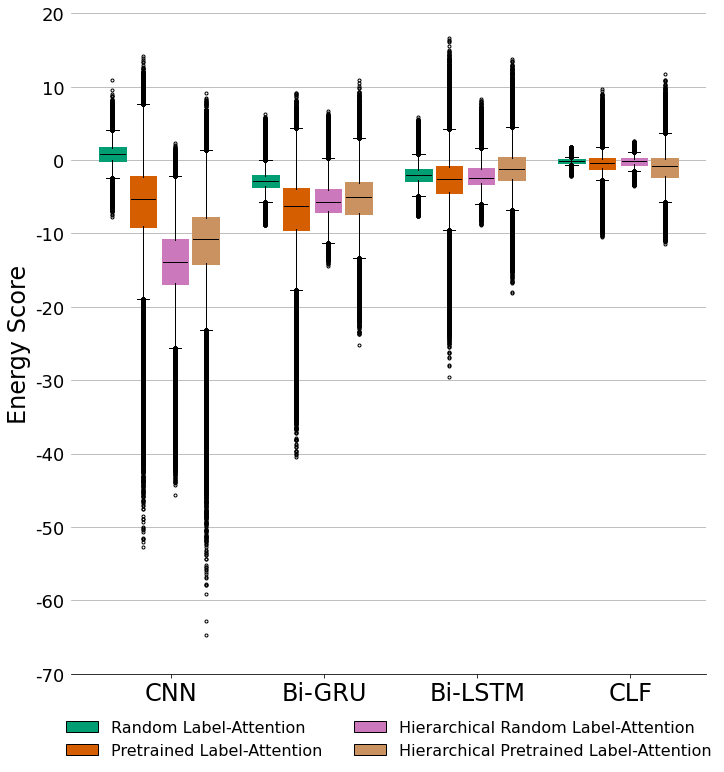

In [68]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
X = np.arange(len(models)) * 22
colors = sns.color_palette('colorblind').as_hex()[2:len(atts)+2]



boxprops = dict(linestyle='--', linewidth=3, color='darkgoldenrod')
flierprops = dict(marker='o', markerfacecolor='green', markersize=12,
                  markeredgecolor='none')

for x, model in zip(X, models):
    for c, (x_delta, att) in enumerate(zip(x_deltas, atts)):
        boxprops = dict(linestyle='-', linewidth=3, color=colors[c], facecolor=colors[c])
        flierprops = dict(marker='.', markersize=6)
        medianprops = dict(linestyle='-', linewidth=1, color='k')

        plt.boxplot(x=d[model][att], widths=3.5, positions=[x + x_delta], patch_artist=True,
                   boxprops=boxprops, flierprops=flierprops, medianprops=medianprops)
    
    
ax.set_xticks(X+0.25)
xlabels = ['CNN', 'Bi-GRU', 'Bi-LSTM', 'CLF']
ax.set_xticklabels(xlabels, fontsize=24)


ax.set_yticklabels([-70, -60, -50, -40, -30, -20, -10, 0, 10, 20], fontsize=18)
ax.set_ylim(-70, 20)

#plt.xlabel('Text Encoder Architecture', fontsize=18)
plt.xlabel('')
plt.ylabel('Energy Score', fontsize=24)

ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.top.set_visible(False)

fig.tight_layout()
plt.grid( which='major', axis='y', zorder=0)
plt.tick_params(left = False)



# generate legend
xlabels = [
                    'Random Label-Attention', 'Pretrained Label-Attention',
                    'Hierarchical Random Label-Attention', 'Hierarchical Pretrained Label-Attention']
legend_elements = []

for color, label in zip(colors, xlabels):
    patch = Patch(facecolor=color, label=label, edgecolor='k')
    legend_elements.append(patch)

plt.legend(loc='lower center', fontsize=16, ncol=2, frameon=False, bbox_to_anchor=(0.5,-0.15),
          handles=legend_elements)

plt.show()

# Discussion Section D: Hierarchical Label-Attention

This notebook shows how hierarchical label-attention improves performance on category-level. We perform the analysis for MIMIC-III-50. The purpose of this analysis is to show, that incorporating high-level category information into the model via the attention mechanism helps improve performance. Specifically, we show the binned performance of the billable codes associated with their respective category.


In [2]:
# Results are stored on an external ssd
path_results = os.path.join(root, 'results')

# Load MIMIC-III-50 codes
with open(os.path.join(root, 'data', 'processed', 'data_Mimic50', 'l_codes_Mimic50.pkl'), 'rb') as f:
    mimic50_labels = pickle.load(f)
    
# Load high-level category mapping to low-level billable codes
with open(os.path.join(root, 'data', 'processed', 'data_Mimic50', 'code_embeddings', 'embedding_matrix_Mimic50_mapping.pkl'), 'rb') as f:
    mimic50_mapping = pickle.load(f)

# Create dictionary using MIMIC-III-50 labels and mapping ids
mimic50_mapping_d = {}
for label, mapping in zip(mimic50_labels, mimic50_mapping):
    mimic50_mapping_d[label] = mapping

In [3]:
def get_larger(diff):
    if diff < 0:
        return 'PT'
    else:
        return 'HPT'

# Load Reults for MIMIC-III-50 on Individual Label-Level

In [4]:
# Load results
df50_ind = pd.read_excel(os.path.join(path_results, 'Mimic50', 'scores_individual_Mimic50.xlsx'))#.drop(['Unnamed: 0'], axis=1)
df50_ind = df50_ind.drop(['Unnamed: 0'], axis=1)
print(f'Shape of results dataframe: {df50_ind.shape}')
print(f'Columns in results dataframe: {df50_ind.columns}')
display(df50_ind.sample(5))

Shape of results dataframe: (400, 65)
Columns in results dataframe: Index(['Model', 'dataset', 'seed', 'doc_max_len', 'batch_size', 'patience',
       'att_module', 'embedding_scaling', 'word_embedding_dim', 'kernel_sizes',
       'hidden_dim', 'dropout_p', 'scale', 'multihead', 'num_heads',
       'f1_micro_038.9', 'f1_micro_244.9', 'f1_micro_250.00', 'f1_micro_272.0',
       'f1_micro_272.4', 'f1_micro_276.1', 'f1_micro_276.2', 'f1_micro_285.1',
       'f1_micro_285.9', 'f1_micro_287.5', 'f1_micro_305.1', 'f1_micro_311',
       'f1_micro_33.24', 'f1_micro_36.15', 'f1_micro_37.22', 'f1_micro_38.91',
       'f1_micro_38.93', 'f1_micro_39.61', 'f1_micro_39.95', 'f1_micro_401.9',
       'f1_micro_403.90', 'f1_micro_410.71', 'f1_micro_412', 'f1_micro_414.01',
       'f1_micro_424.0', 'f1_micro_427.31', 'f1_micro_428.0', 'f1_micro_45.13',
       'f1_micro_486', 'f1_micro_496', 'f1_micro_507.0', 'f1_micro_511.9',
       'f1_micro_518.81', 'f1_micro_530.81', 'f1_micro_584.9',
       'f1_micr

,Model,dataset,seed,doc_max_len,batch_size,patience,att_module,embedding_scaling,word_embedding_dim,kernel_sizes,...,f1_micro_96.04,f1_micro_96.6,f1_micro_96.71,f1_micro_96.72,f1_micro_99.04,f1_micro_99.15,f1_micro_995.92,f1_micro_V15.82,f1_micro_V45.81,f1_micro_V58.61
125,BiGRU,Mimic50,25,3000,16,10,random,0.5,100,none,...,0.621,0.671,0.542,0.660,0.284,0.463,0.605,0.0,0.797,0.629
185,BiGRU,Mimic50,42,3000,16,10,random,0.5,100,none,...,0.616,0.644,0.631,0.547,0.085,0.379,0.625,0.0,0.812,0.648
306,CLF,Mimic50,25,4096,4,10,hierarchical_pretrained,0.5,300,none,...,0.675,0.645,0.650,0.623,0.162,0.586,0.607,0.0,0.814,0.642
390,CLF,Mimic50,87,4096,4,10,random,0.5,300,none,...,0.672,0.659,0.615,0.697,0.182,0.627,0.602,0.0,0.791,0.631
224,BiLSTM,Mimic50,25,3000,16,10,random,0.5,200,none,...,0.584,0.684,0.644,0.689,0.209,0.451,0.496,0.0,0.787,0.584


In [5]:
# Need to reshape dataframe for analysis
# remove unnecessary columns
df50_ind_melt = df50_ind.drop(['dataset', 'doc_max_len', 'batch_size', 'patience',
                               'embedding_scaling', 'word_embedding_dim', 'kernel_sizes',
                               'hidden_dim', 'dropout_p', 'scale', 'multihead', 'num_heads'], axis=1)
# Collaps data onto the variables 'Model', 'att_module', 'seed'
df50_ind_melt = pd.melt(df50_ind_melt, id_vars=['Model', 'att_module', 'seed'])
df50_ind_melt = df50_ind_melt.sort_values(['Model', 'att_module', 'variable']).reset_index(drop=True)
    
# Retrieve labels from column name
df50_ind_melt[['metric', 'average', 'label']] = df50_ind_melt.variable.str.split('_', expand=True)
    
# Drop all redundant or non-informative columns
df50_ind_melt = df50_ind_melt.drop(['metric', 'average', 'variable'], axis=1)

# Add category
df50_ind_melt['cat'] = df50_ind_melt.apply(lambda x: mimic50_mapping_d[x.label], axis=1)

# Rename column names
df50_ind_melt = df50_ind_melt.rename(columns = {'Model': 'model', 'att_module': 'att'})

# Rename values in columns model and att

df50_ind_melt.att = df50_ind_melt.att.map({'random': 'Random Label Attention',
                                   'pretrained': 'Pretrained Label Attention',
                                   'hierarchical_random': 'Hierarchical Random Label Attention',
                                   'hierarchical_pretrained': 'Hierarchical Pretrained Label Attention'})

df50_ind_melt.model = df50_ind_melt.model.map({'BiGRU': 'Bi-GRU', 'BiLSTM': 'Bi-LSTM', 'CNN': 'CNN', 'CLF': 'CLF'})

In [6]:
# Retrieve results from the pretrained label-attention mechanism
df50_ind_melt_pt = df50_ind_melt[df50_ind_melt['att'].isin(['Hierarchical Pretrained Label Attention',
                                                  'Pretrained Label Attention'])]
df50_ind_melt_pt

,model,att,seed,value,label,cat
0,Bi-GRU,Hierarchical Pretrained Label Attention,13,0.475,038.9,0
1,Bi-GRU,Hierarchical Pretrained Label Attention,25,0.420,038.9,0
2,Bi-GRU,Hierarchical Pretrained Label Attention,42,0.503,038.9,0
3,Bi-GRU,Hierarchical Pretrained Label Attention,87,0.505,038.9,0
4,Bi-GRU,Hierarchical Pretrained Label Attention,111,0.477,038.9,0
...,...,...,...,...,...,...
18745,CNN,Pretrained Label Attention,13,0.656,V58.61,9
18746,CNN,Pretrained Label Attention,25,0.631,V58.61,9
18747,CNN,Pretrained Label Attention,42,0.670,V58.61,9
18748,CNN,Pretrained Label Attention,87,0.632,V58.61,9


In [7]:
df50_ind_final = df50_ind_melt_pt.groupby(['model', 'att', 'cat'])['value'].mean().reset_index()
df50_ind_final = df50_ind_final.pivot_table(values='value', index=['model', 'cat'], columns='att').reset_index()
df50_ind_final.head(3)

att,model,cat,Hierarchical Pretrained Label Attention,Pretrained Label Attention
0,Bi-GRU,0,0.491360,0.449920
1,Bi-GRU,1,0.558213,0.477673
2,Bi-GRU,2,0.214053,0.192947


In [8]:
# Compute performance difference between pretrained hierarchical label-attention and pretrained label-attention
df50_ind_final['diff'] = df50_ind_final['Hierarchical Pretrained Label Attention'] - df50_ind_final['Pretrained Label Attention']
# Get indicator variable
df50_ind_final['larger'] = df50_ind_final.apply(lambda x: get_larger(x['diff']), axis=1)
df50_ind_final.head(3)

att,model,cat,Hierarchical Pretrained Label Attention,Pretrained Label Attention,diff,larger
0,Bi-GRU,0,0.491360,0.449920,0.041440,HPT
1,Bi-GRU,1,0.558213,0.477673,0.080540,HPT
2,Bi-GRU,2,0.214053,0.192947,0.021107,HPT


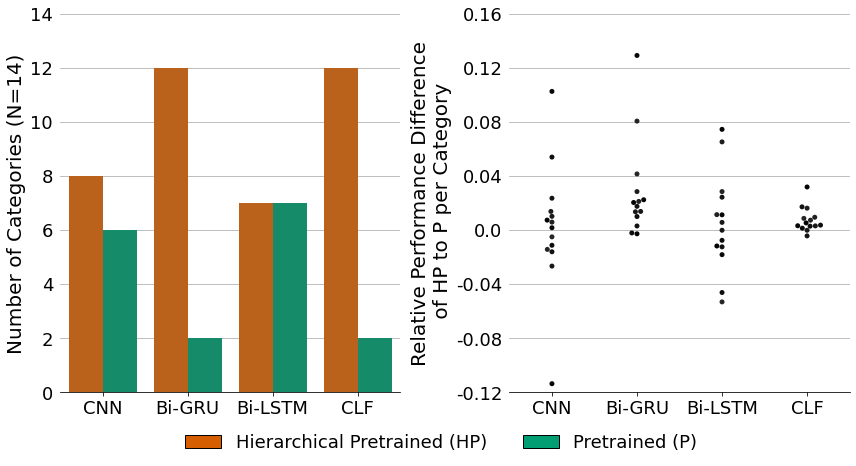

In [9]:
order = ['CNN', 'Bi-GRU', 'Bi-LSTM', 'CLF']
hue_order = ['Hierarchical Pretrained (HP)', 'Pretrained (P)']

colors = ['#d55e00', '#029e73']
fig, axs = plt.subplots(figsize=(12, 6), facecolor='white', ncols=2)

sns.countplot(data=df50_ind_final, x='model', hue='larger', ax=axs[0],
             order=order, palette=colors)

palette = sns.light_palette('#d55e00', n_colors=24)[10:] # sns.color_palette('#d55e00', n_colors=14 )


sns.swarmplot(data=df50_ind_final, x='model', y='diff', hue='cat', order=order, palette='dark:k') #palette=palette) #palette=palette


for i, ax in enumerate(axs):
    ax.spines.right.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.tick_params(left=False)
    ax.grid(which='major', axis='y', zorder=0)
    
    if i == 0:
        ax.set_ylabel('Number of Categories (N=14)', fontsize=20)
        ax.set_yticks(np.round(np.arange(0, 15, 2), 1))
        ax.set_yticklabels(labels=np.round(np.arange(0, 15, 2), 1), fontsize=18)
        ax.set_xlabel('')
        ax.set_xticks([0, 1, 2, 3])
        ax.set_xticklabels(order, fontsize=18, rotation=0)
        ax.get_legend().remove()
        ax.set_axisbelow(True)
    elif i == 1:
        #ax.axhline(0, color='#029e73', linestyle='--', lw=3)
        ax.set_ylabel('Relative Performance Difference\n of HP to P per Category',
                      fontsize=20)
        ax.set_ylim(-0.12, 0.15)
        ax.set_yticks(np.round(np.arange(-0.12, 0.16, 0.04), 2))
        ax.set_yticklabels(labels=np.round(np.arange(-0.12, 0.16, 0.04), 2), fontsize=18)
        ax.set_xlabel('')
        ax.set_xticks([0, 1, 2, 3])
        ax.set_xticklabels(order, fontsize=18)
        #ax.text(1.3, -0.11, 'Index: Category-wise\nPerformance of Pretrained\nLabel Attention',
        #        weight='bold', fontsize=12, fontstyle='oblique')
        #ax.annotate('', xy=(2.5, 0), weight='bold',
        #     xytext=(2.3, -0.08), arrowprops=dict(arrowstyle="-|>", color='k', lw=2))

plt.tight_layout()

legend_elements = []

for color, label in zip(colors, hue_order):
    patch = Patch(facecolor=color, label=label, edgecolor='k')
    legend_elements.append(patch)

plt.legend(loc='lower left', fontsize=18, ncol=2, frameon=False, 
           bbox_to_anchor=(-1,-0.2),
          handles=legend_elements)

plt.show()